# Probabilistic Decision Making vs. Statistical Significance


This notebook will walk through a concrete set of experiments where you can see the effect of making a decision using null hypothesis significance testing (NHST) via statistical significance or probabilistic decision making via expected utility. At the end we'll see which provides the most value. In addition, you can see what happens over the long run if you make these sorts of decisions. For a nice intro to probabilistic decision making see [this short video](https://www.nytimes.com/video/business/100000004868264/making-choices-like-a-poker-champ.html?partner=slack&smid=sl-share).


Notice that with NHST you're asking something like "is it very likely that these two are different" and with probabilistic decision making you're asking something like "how often will I be wrong if I make this decision."


We'll consider experiments with different ground truths:


1. Treatment and Control are the same<br>
2. Treatment is better than Control<br>
3. Treatment is worse than Control<br>




In [1]:
// How many simulations of experiments do you want to run
val numberOfExperimentsToRun: Int = 10000
// What should the average value of your control or treatment be
val rangeOfMeans: (Double, Double) = (-100, 100)
// How many of the experiments will have a control that is the same as the treatment
// (the remainder will be evenly split be better or worse)
val percentNoDifference: Double = 0.5
// How many units (or users) will be in each sample
val unitsPerTreatment: Int = 1000

In [2]:
case class Experiment(
    controlMean: Double, 
    controlStandardDeviation: Double, 
    treatmentMean: Double, 
    treatmentStandardDeviation: Double,
    truth: String)

// evaluates to (
//    stat sig,
//    expected utility greater than 50%, 
//    does the sample reflect the direction of the population
// )
def runAnExperiment(e: Experiment): (Boolean, Boolean, Boolean) = {

    import org.apache.commons.math3.distribution.NormalDistribution
    import org.apache.commons.math3.stat.inference.TTest
    import org.apache.commons.math3.stat.descriptive.moment.StandardDeviation

    val units = unitsPerTreatment

    val controlPopulation = new NormalDistribution(e.controlMean, e.controlStandardDeviation)
    val treatmentPopulation = new NormalDistribution(e.treatmentMean, e.treatmentStandardDeviation)

    val controlSample = List.fill(units)(controlPopulation.sample())
    val treatmentSample = List.fill(units)(treatmentPopulation.sample())
    
    val pValue = (new TTest()).tTest(controlSample.toArray, treatmentSample.toArray)

    val controlSamplingStandardDeviation = (new StandardDeviation().evaluate(controlSample.toArray)) / Math.sqrt(units)
    val treatmentSamplingStandardDeviation = (new StandardDeviation().evaluate(treatmentSample.toArray)) / Math.sqrt(units)

    val controlSamplingDistribution = new NormalDistribution(controlSample.sum / controlSample.size, controlSamplingStandardDeviation)
    val treatmentSamplingDistribution = new NormalDistribution(treatmentSample.sum / treatmentSample.size, treatmentSamplingStandardDeviation)

    // Monte Carlo simulation for number of times control wins over treatment
    val (controlWins, treatmentWins) = (for (i <- 0 until 10000) yield {
        val controlSample = controlSamplingDistribution.sample() 
        val treatmentSample = treatmentSamplingDistribution.sample()
        if (controlSample > treatmentSample) {
            (1,0)
        } else if (controlSample == treatmentSample) {
            // if it's a tie, then flip a coin
            if (scala.util.Random.nextDouble > 0.5) {
                (1,0)
            } else {
                (0,1)
            }
        }
        else {
            (0,1)
        }
    }).foldLeft((0,0))((acc, elem) => {
        (acc._1 + elem._1, acc._2 + elem._2)
    })

    // Convert number of wins to probability of winning
    val pWinControl = controlWins / 100.0
    val pWinTreatment = treatmentWins / 100.0

    // We know the true population mean, was the direction of the samples correct?
    // We want to know this to see if our p-value is in the right direction.
    val sampleAgreesWithTruth = (
        e.controlMean > e.treatmentMean && ((controlSample.sum / controlSample.length) > (treatmentSample.sum / treatmentSample.length)) ||
        e.controlMean < e.treatmentMean && ((controlSample.sum / controlSample.length) < (treatmentSample.sum / treatmentSample.length))
    )

    // (bool, bool, bool)
    (pValue <= 0.05, pWinTreatment > 50, sampleAgreesWithTruth)
}

In [3]:
import scala.util.Random

def generateExperiment() = {
    val (lowerMean, upperMean) = rangeOfMeans
    val controlMean = lowerMean + Random.nextDouble * (upperMean - lowerMean)
    val controlStandardDeviation = Math.abs(controlMean * 0.005 + Random.nextDouble * (controlMean * 0.5 - controlMean * 0.005))
    val (treatmentMean, treatmentStandardDeviation) = {
        if (Random.nextDouble <= percentNoDifference) {
            (controlMean, controlStandardDeviation)
        } else {
            val m = lowerMean + Random.nextDouble * (upperMean - lowerMean)
            val sd = Math.abs(m * 0.005 + Random.nextDouble * (m * 0.5 - m * 0.0005))
            (m, sd)
        }
    }

    val truth = {
        if (controlMean == treatmentMean && controlStandardDeviation == treatmentStandardDeviation) {
            "same"
        } else if (controlMean > treatmentMean) {
            "worse"
        } else {
            "better"
        }
    }

    Experiment(
        controlMean,
        controlStandardDeviation,
        treatmentMean,
        treatmentStandardDeviation,
        truth
    )
}

val experiments = List.fill(numberOfExperimentsToRun)(generateExperiment)

// (stat sig times correct, EU times correct), (both correct, EU only correct, stat sig only correct)
val timesCorrect: List[((Boolean, Boolean),(Int, Int, Int))] = for (e <- experiments) yield {
    val (statSig, probabilistic, directionallyRepresentativeSample) = runAnExperiment(e)
    val statSigInTheRightDirection = statSig && directionallyRepresentativeSample
    val times = {
        if (e.truth == "same") {
            (!statSig, true)
        } else if (e.truth == "better") {
            (statSigInTheRightDirection, probabilistic)
        } else {
            (statSigInTheRightDirection, !probabilistic)
        }
    }

    val comparison =
        (
        {
            if ((e.truth == "same" && !statSig) || 
                (e.truth == "better" && statSigInTheRightDirection && probabilistic) || 
                (e.truth == "worse" && statSigInTheRightDirection && !probabilistic)) { 1 }
            else 0
        },
        {
            if ((e.truth == "same" && statSig) || 
                (e.truth == "better" && !statSig && probabilistic) || 
                (e.truth == "worse" && !statSig && !probabilistic)) { 1 }
            else 0
        },
        {
            if ((e.truth == "better" && statSigInTheRightDirection && !probabilistic) || 
                (e.truth == "worse" && statSigInTheRightDirection && probabilistic)) { 1 }
            else 0
        }
        )
    (times, comparison)
}

val countTimesCorrect: ((Int, Int), (Int, Int, Int)) = timesCorrect.foldLeft(((0,0), (0,0,0)))((acc, elem) => {
        def toInt(b:Boolean) = if (b) 1 else 0
        val (times, comparisons) = acc
        val (bools, ints) = elem
        ((times._1 + toInt(bools._1), times._2 + toInt(bools._2)),
        (comparisons._1 + ints._1, comparisons._2 + ints._2, comparisons._3 + ints._3))
    })

countTimesCorrect


Tuple2(
  _1 = Tuple2(
    _1 = 9673,
    _2 = 9984
  ),
  _2 = Tuple3(
    _1 = 9673,
    _2 = 311,
    _3 = 0
  )
)


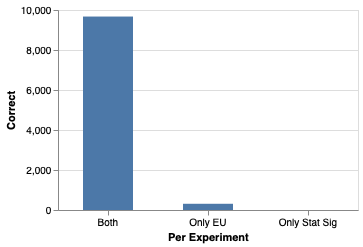

In [5]:
{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "description": "A simple bar chart with embedded data.",
  "width": 300,
  "data": {
    "values": [
      {"Per Experiment": "Both", "Correct": countTimesCorrect._2._1}, 
      {"Per Experiment": "Only EU", "Correct": countTimesCorrect._2._2},
      {"Per Experiment": "Only Stat Sig", "Correct": countTimesCorrect._2._3},
    ]
  },
  "mark": {
    "type": "bar",
    "width": 50,
    "x": 100,
    "strokeWidth": 200
  },
  "encoding": {
    "x": {"field": "Per Experiment", "type": "nominal", "axis": {"labelAngle": 0}},
    "y": {"field": "Correct", "type": "quantitative"}
  }
}